# Cross-Asset Volatility Modeling & Risk Forecasting (GARCH-t)

This notebook:
- Downloads adjusted prices for **JPM, XOM, GE, KO, IBM, DIS** (2000–2024)
- Fits **GARCH(1,1)** with **Student-t** innovations per asset
- Builds a **conditional covariance** matrix: \(\Sigma_t = D_t R_t D_t\)
- Solves a **long-only minimum-variance** allocation using that conditional covariance
- Computes **conditional 1-day VaR / ES** and **VaR backtest (Kupiec test)**

> Tip: Run the cells top-to-bottom.


In [1]:
# Colab installs (run once per session)
!pip -q install yfinance arch cvxpy statsmodels



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 17.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from arch import arch_model
from scipy.stats import t, chi2

from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera

import cvxpy as cp

plt.rcParams["figure.figsize"] = (12, 5)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

In [5]:
# -------------------------------
# 1) PARAMETERS
# -------------------------------
assets = ["JPM", "XOM", "GE", "KO", "IBM", "DIS"]
start_date = "2000-01-01"
end_date   = "2024-12-31"

window_corr = 252           # ~1 trading year rolling correlation
confidence  = 0.99          # VaR / ES confidence level
scale_pct   = 100.0         # ARCH package fits nicer on % returns

In [6]:
# -------------------------------
# 2) DATA DOWNLOAD & RETURNS
# -------------------------------
prices = yf.download(assets, start=start_date, end=end_date, auto_adjust=True)["Close"]
prices = prices.dropna(how="all")
returns = np.log(prices / prices.shift(1)).dropna()

display(prices.tail())
display(returns.tail())

[*********************100%***********************]  6 of 6 completed


Ticker,DIS,GE,IBM,JPM,KO,XOM
Date,,,,,,
2024-12-23,110.181488,167.788971,216.340286,232.399857,60.592327,102.536774
2024-12-24,111.328789,170.240982,218.757843,236.221359,61.039146,102.633224
2024-12-26,111.318909,170.896149,219.225754,237.030487,60.776882,102.720032
2024-12-27,110.329849,169.116302,217.168900,235.109985,60.660324,102.710396
2024-12-30,109.588051,167.147522,214.702621,233.306473,60.252357,102.015884


Ticker,DIS,GE,IBM,JPM,KO,XOM
Date,,,,,,
2024-12-23,-0.005639,0.003853,-0.006423,0.003319,-0.002721,0.004053
2024-12-24,0.010359,0.014508,0.011113,0.016310,0.007347,0.000940
2024-12-26,-0.000089,0.003841,0.002137,0.003419,-0.004306,0.000845
2024-12-27,-0.008925,-0.010469,-0.009427,-0.008135,-0.001920,-0.000094
2024-12-30,-0.006746,-0.011710,-0.011421,-0.007701,-0.006748,-0.006785


,Mean,Std Dev,Skewness,Kurtosis (excess)
Ticker,,,,
DIS,0.000251,0.019244,-0.042895,9.678578
GE,0.000040,0.020907,-0.047668,7.365522
IBM,0.000210,0.016275,-0.291552,8.740497
JPM,0.000369,0.023417,0.226923,14.549871
KO,0.000237,0.012905,-0.198623,9.410263
XOM,0.000283,0.016570,-0.056639,8.749718


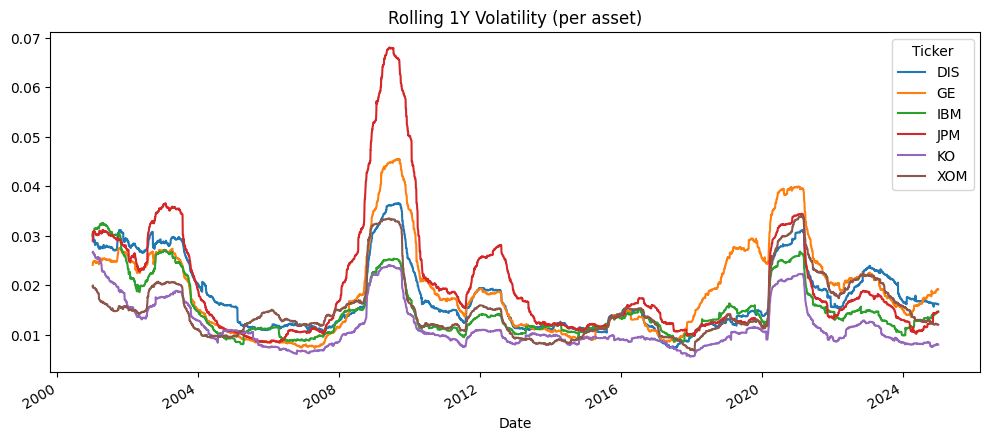

In [7]:
# -------------------------------
# 3) DESCRIPTIVE STATISTICS
# -------------------------------
desc_stats = pd.DataFrame({
    "Mean": returns.mean(),
    "Std Dev": returns.std(),
    "Skewness": returns.skew(),
    "Kurtosis (excess)": returns.kurtosis()
})
display(desc_stats)

# quick visual
returns.rolling(252).std().plot(title="Rolling 1Y Volatility (per asset)")
plt.show()

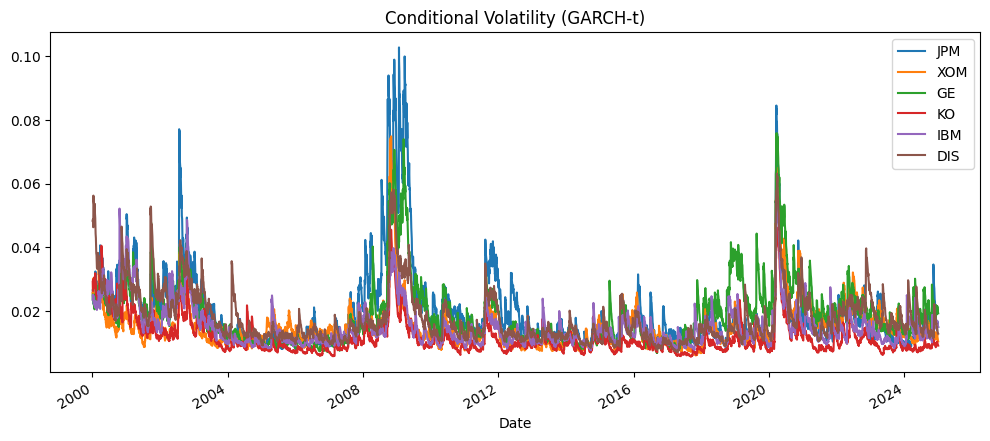

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          JPM   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -12072.1
Distribution:      Standardized Student's t   AIC:                           24154.1
Method:                  Maximum Likelihood   BIC:                           24187.9
                                              No. Observations:                 6287
Date:                      Mon, Jan 19 2026   Df Residuals:                     6286
Time:                              16:56:37   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [8]:
# -------------------------------
# 4) UNIVARIATE GARCH(1,1) WITH STUDENT-t
# -------------------------------
garch_results = {}
cond_vol = pd.DataFrame(index=returns.index, columns=assets, dtype=float)

for a in assets:
    model = arch_model(returns[a] * scale_pct, vol="Garch", p=1, q=1, dist="t", mean="Constant")
    res = model.fit(disp="off")
    garch_results[a] = res
    # conditional volatility returned in same units as the fitted series (%)
    cond_vol[a] = res.conditional_volatility / scale_pct  # back to return units

# Plot conditional vols
cond_vol.plot(title="Conditional Volatility (GARCH-t)")
plt.show()

# Show one model summary (pick JPM)
print(garch_results["JPM"].summary())

In [9]:
# -------------------------------
# 5) DIAGNOSTICS (Quant-relevant tests)
#    - Ljung-Box on residuals: remaining autocorrelation?
#    - Ljung-Box on squared residuals: remaining ARCH/vol clustering?
#    - ARCH-LM test: leftover heteroskedasticity?
#    - Jarque-Bera: non-normality sanity check
# -------------------------------
def diagnostics_table(res, lags=20):
    # standardized residuals
    std_resid = res.std_resid.dropna()

    lb_resid = acorr_ljungbox(std_resid, lags=[lags], return_df=True)
    lb_sq    = acorr_ljungbox(std_resid**2, lags=[lags], return_df=True)
    jb_stat, jb_p, _, _ = jarque_bera(std_resid)

    arch_lm = het_arch(std_resid, nlags=lags)

    return {
        "LB(resid) p": float(lb_resid["lb_pvalue"].iloc[0]),
        "LB(resid^2) p": float(lb_sq["lb_pvalue"].iloc[0]),
        "ARCH-LM p": float(arch_lm[1]),
        "JB p": float(jb_p),
        "nu (t df)": float(res.params.get("nu", np.nan))
    }

diag = pd.DataFrame({a: diagnostics_table(garch_results[a], lags=20) for a in assets}).T
display(diag.sort_values("LB(resid^2) p"))


,LB(resid) p,LB(resid^2) p,ARCH-LM p,JB p,nu (t df)
JPM,0.568243,0.244575,0.308029,0.000000,5.473760
GE,0.366572,0.344883,0.349653,0.000000,5.155640
XOM,0.120219,0.396094,0.458701,0.000000,7.713371
IBM,0.406894,0.945166,0.926672,0.000000,4.293496
KO,0.545978,0.955294,0.955120,0.000000,4.988247
DIS,0.854105,0.997214,0.996942,0.000000,4.817335


In [10]:
# -------------------------------
# 6) CONDITIONAL COVARIANCE: Sigma_t = D_t R_t D_t
# -------------------------------
# pick an evaluation date (last available)
date = cond_vol.dropna().index[-1]

# rolling correlation estimate (from returns up to that date)
R_t = returns.loc[:date].tail(window_corr).corr().values

# diagonal matrix of conditional vols at date
D_t = np.diag(cond_vol.loc[date].values)

Sigma_t = D_t @ R_t @ D_t

Sigma_df = pd.DataFrame(Sigma_t, index=assets, columns=assets)
display(Sigma_df)

# sanity: should be symmetric and PSD-ish (numerical small negatives possible)
eigvals = np.linalg.eigvalsh(Sigma_t)
print("Min eigenvalue:", eigvals.min())


,JPM,XOM,GE,KO,IBM,DIS
JPM,0.000225,0.000018,0.000056,0.000036,0.000008,0.000034
XOM,0.000018,0.000109,0.000045,0.000026,-0.000017,0.000008
GE,0.000056,0.000045,0.000372,0.000050,0.000048,0.000040
KO,0.000036,0.000026,0.000050,0.000083,0.000007,0.000036
IBM,0.000008,-0.000017,0.000048,0.000007,0.000225,0.000033
DIS,0.000034,0.000008,0.000040,0.000036,0.000033,0.000165


Min eigenvalue: 5.76914973819195e-05


In [11]:
# -------------------------------
# 7) PORTFOLIO OPTIMIZATION (Long-only min variance)
# -------------------------------
n = len(assets)
w = cp.Variable(n)

objective = cp.Minimize(cp.quad_form(w, Sigma_t))
constraints = [cp.sum(w) == 1, w >= 0]

problem = cp.Problem(objective, constraints)
problem.solve()

weights = pd.Series(np.array(w.value).ravel(), index=assets)
display(weights.sort_values(ascending=False))
print("Sum weights:", weights.sum())

,0
XOM,0.314628
KO,0.300259
IBM,0.179525
DIS,0.117785
JPM,0.087804
GE,-0.000000


Sum weights: 1.0


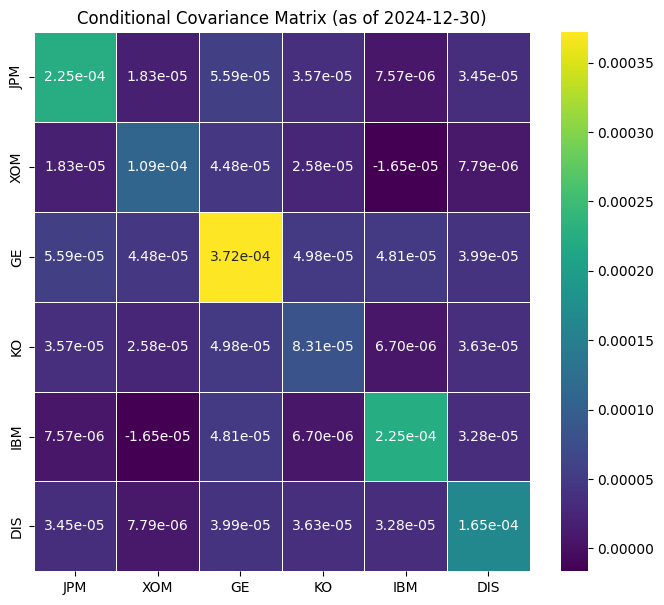

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 7))
sns.heatmap(Sigma_df, annot=True, cmap='viridis', fmt=".2e", linewidths=.5)
plt.title(f"Conditional Covariance Matrix (as of {date.date()})")
plt.show()

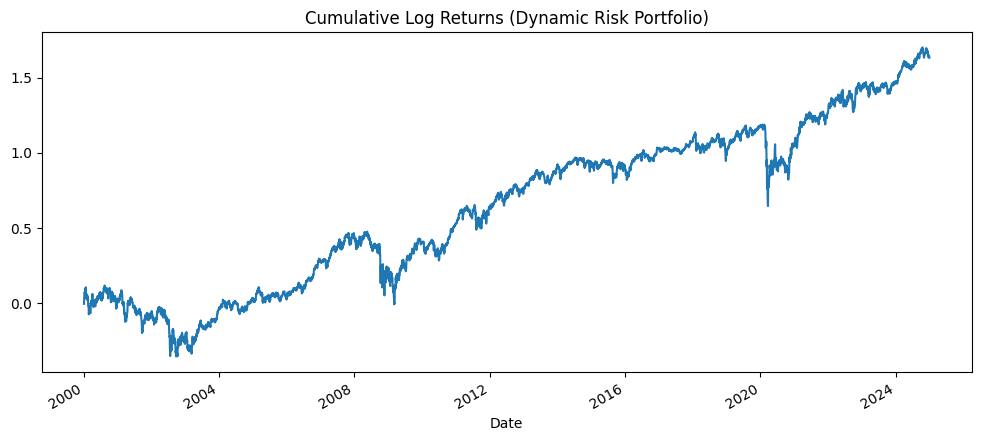

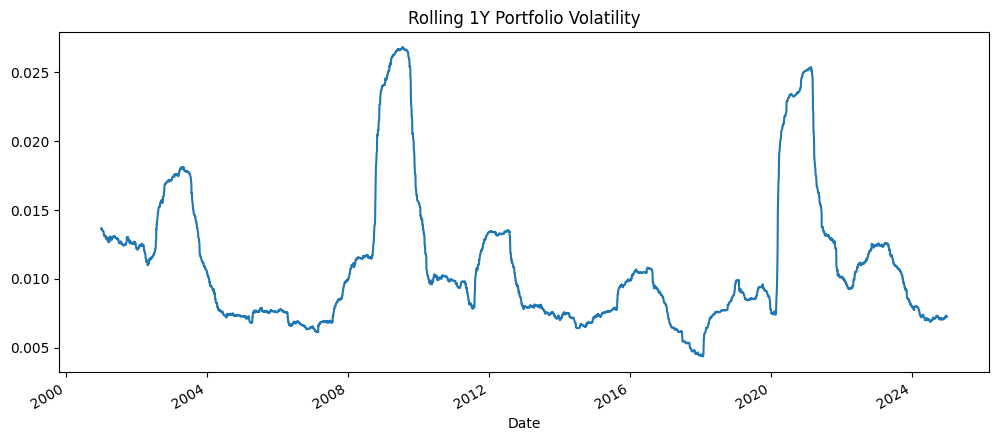

In [12]:
# -------------------------------
# 8) PORTFOLIO RETURNS & ROLLING VOL
# -------------------------------
portfolio_returns = returns @ weights

portfolio_returns.cumsum().plot(title="Cumulative Log Returns (Dynamic Risk Portfolio)")
plt.show()

portfolio_returns.rolling(window_corr).std().plot(title="Rolling 1Y Portfolio Volatility")
plt.show()

In [13]:
# -------------------------------
# 9) CONDITIONAL 1-DAY VaR & ES (Student-t)
# -------------------------------
# Conditional portfolio sigma from Sigma_t
w_vec = weights.values.reshape(-1, 1)
sigma_p_t = float(np.sqrt(w_vec.T @ Sigma_t @ w_vec))

# Student-t df: average of fitted nu (simple, transparent baseline)
df_t = float(np.mean([garch_results[a].params.get("nu", np.nan) for a in assets]))

# Mean estimate (often ~0; use rolling mean for stability)
mu_p_t = float(portfolio_returns.loc[:date].tail(window_corr).mean())

q = float(t.ppf(1 - confidence, df_t))  # left-tail quantile

VaR_t = mu_p_t + sigma_p_t * q

# ES for Student-t (left tail)
x = q
ES_t = mu_p_t + sigma_p_t * ((t.pdf(x, df_t) / (1 - confidence)) * ((df_t + x**2) / (df_t - 1)))

print(f"Date: {date.date()}")
print(f"Conditional sigma_p: {sigma_p_t:.4%}")
print(f"{int(confidence*100)}% 1d VaR (return): {VaR_t:.4%}")
print(f"{int(confidence*100)}% 1d ES  (return): {ES_t:.4%}")

Date: 2024-12-30
Conditional sigma_p: 0.6457%
99% 1d VaR (return): -2.0387%
99% 1d ES  (return): 2.8144%


/tmp/ipython-input-1372576463.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_p_t = float(np.sqrt(w_vec.T @ Sigma_t @ w_vec))


/tmp/ipython-input-2452824566.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_p = float(np.sqrt(w_vec.T @ Sigma @ w_vec))


Observations: 6287
Breaches: 24  (expected ~ 62.9)
Kupiec LR_uc: 31.7575  p-value: 0.0000


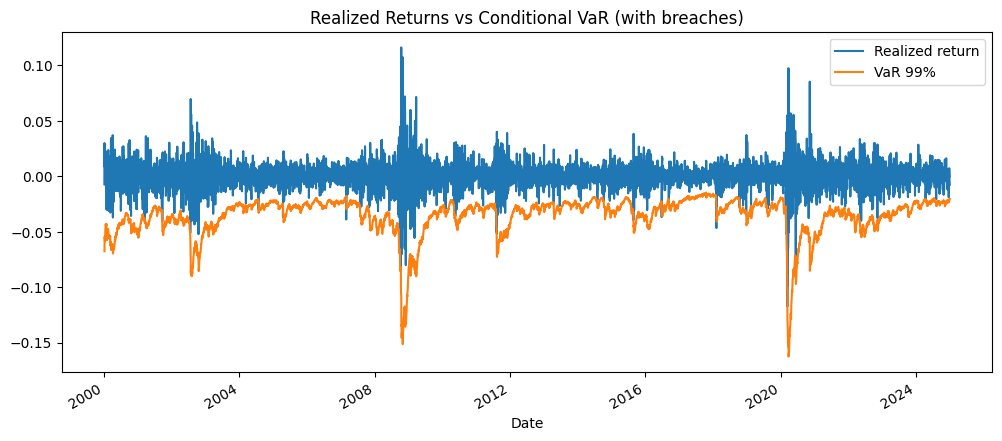

In [14]:
# -------------------------------
# 10) VaR BACKTEST (Kupiec Unconditional Coverage)
# -------------------------------
# We'll compute a rolling conditional VaR series using:
# - per-asset conditional vols from GARCH
# - rolling correlations from returns
# - fixed weights (from the last Sigma_t optimization)

cond_vol_bt = cond_vol.dropna()
dates_bt = cond_vol_bt.index

var_series = pd.Series(index=dates_bt, dtype=float)

for d in dates_bt:
    R = returns.loc[:d].tail(window_corr).corr().values
    D = np.diag(cond_vol_bt.loc[d].values)
    Sigma = D @ R @ D
    sigma_p = float(np.sqrt(w_vec.T @ Sigma @ w_vec))
    mu_p = float(portfolio_returns.loc[:d].tail(window_corr).mean())
    var_series.loc[d] = mu_p + sigma_p * q

# Align realized returns to VaR dates
realized = portfolio_returns.reindex(var_series.index)

breach = (realized < var_series).astype(int)
n = breach.count()
x = breach.sum()
p = 1 - confidence

# Kupiec test statistic
# Handle edge cases x=0 or x=n safely.
phat = x / n if n > 0 else np.nan

def safe_log(z):
    return np.log(z) if z > 0 else -np.inf

num = (1-p)**(n-x) * (p**x)
den = (1-phat)**(n-x) * (phat**x) if 0 < phat < 1 else 0.0

LR_uc = -2 * (safe_log(num) - safe_log(den)) if den > 0 else np.nan
p_value = 1 - chi2.cdf(LR_uc, df=1) if np.isfinite(LR_uc) else np.nan

print(f"Observations: {n}")
print(f"Breaches: {x}  (expected ~ {n*p:.1f})")
print(f"Kupiec LR_uc: {LR_uc:.4f}  p-value: {p_value:.4f}")

# Plot breaches
plt.figure(figsize=(12,5))
realized.plot(label="Realized return")
var_series.plot(label=f"VaR {int(confidence*100)}%")
plt.legend()
plt.title("Realized Returns vs Conditional VaR (with breaches)")
plt.show()

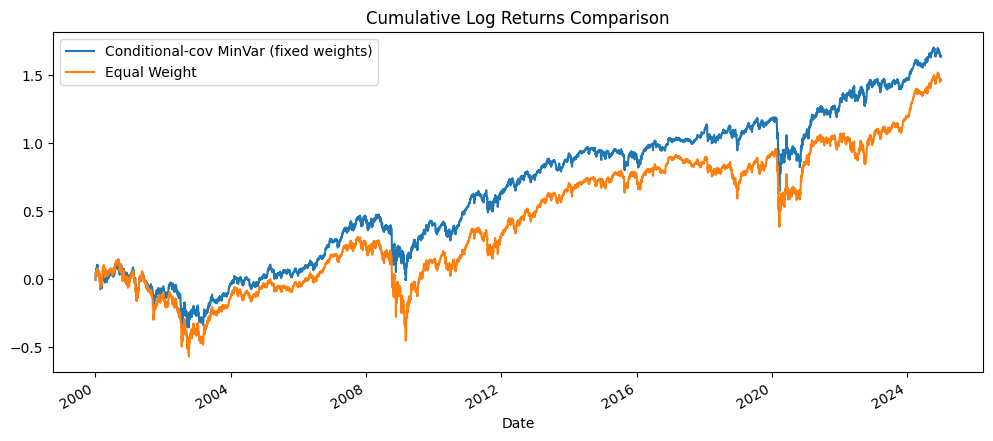

,Dynamic Risk Portfolio,Equal Weight
Ann Return,0.065427,0.058373
Ann Vol,0.190185,0.212532
Sharpe,0.344017,0.274653
Max Drawdown (log),-0.542429,-0.760621


In [15]:
# -------------------------------
# 11) PERFORMANCE COMPARISON: Equal-weight baseline
# -------------------------------
equal_weight = pd.Series(1/len(assets), index=assets)
ew_returns = returns @ equal_weight

plt.figure(figsize=(12,5))
portfolio_returns.cumsum().plot(label="Conditional-cov MinVar (fixed weights)")
ew_returns.cumsum().plot(label="Equal Weight")
plt.legend()
plt.title("Cumulative Log Returns Comparison")
plt.show()


def perf_stats(r):
    ann = 252
    mu = r.mean() * ann
    vol = r.std() * np.sqrt(ann)
    sharpe = mu / vol if vol > 0 else np.nan
    dd = (r.cumsum() - r.cumsum().cummax()).min()
    return pd.Series({"Ann Return": mu, "Ann Vol": vol, "Sharpe": sharpe, "Max Drawdown (log)": dd})

display(pd.DataFrame({
    "Dynamic Risk Portfolio": perf_stats(portfolio_returns),
    "Equal Weight": perf_stats(ew_returns)
}))